# Building Custom Dataset

In [1]:
root_dir = "/content/drive/MyDrive/Sign_Language_Detection/dataset"
csv_dir = "/content/drive/MyDrive/Sign_Language_Detection/dataset/dataset.csv"

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from skimage import io

from torch.utils.data import Dataset

class SignLanguageDataset(Dataset):
  def __init__(self, csv_file, root_dir, transform=None):
    self.dataset_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    self.transform = transform

  def __len__(self):
    return len(self.dataset_frame)
  
  def __getitem__(self, index):
    image_name = os.path.join(self.root_dir, self.dataset_frame.iloc[index, 0])
    image = cv2.imread(image_name)
    # Image is already read in RGB format, since image was stored in BGR format

    y_label = self.dataset_frame.iloc[index,1]

    if self.transform:
      image = self.transform(image)
    
    return (image, y_label)

In [3]:
sign_lang_dataset = SignLanguageDataset(csv_file=csv_dir, root_dir=root_dir)
print(f'Length of dataset: {len(sign_lang_dataset)}')

Length of dataset: 1680


In [4]:
classes = ['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']

Image shape: (100, 100, 3)


Text(0.5, 1.0, 'A')

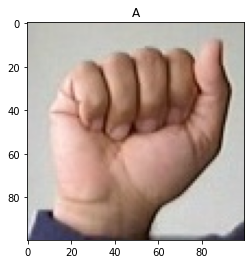

In [5]:
import matplotlib.pyplot as plt

# Display a couple of images from dataset
idx = 1441
image, label = sign_lang_dataset[idx]
print(f'Image shape: {image.shape}')


plt.imshow(image, cmap='gray')
plt.title(classes[label])

In [5]:
import cv2
import torch
from torchvision import transforms, utils

class Normalize(object):
  """Convert the color image to grayscale image and normalize the color range to [0,1]"""
  def __call__(self, sample):
    image = sample

    image_copy = np.copy(image)

    # convert image to grayscale
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_RGB2GRAY)

    # scale range [0,1]
    image_copy = image_copy / 255.0

    return image_copy
  
class Rescale(object):
  """Rescale the image to a given size"""
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    self.output_size = output_size

  def __call__(self, sample):
    image = sample
    h,w = image.shape[:2]
    if isinstance(self.output_size, int):
      if h>w:
        new_h, new_w = self.ouptut_size * h/w, self.output_size
      else:
        new_h, new_w = self.output_size, self.output_size * w/h
    else:
      new_h, new_w = self.output_size
    
    new_h, new_w = int(new_h), int(new_w)
    img = cv2.resize(image, (new_w, new_h))
    return img

class RandomCrop(object):
  """Crop randomly the image in a sample"""
  def __init__(self, output_size):
    assert isinstance(output_size, (int, tuple))
    if isinstance(output_size, int):
      self.output_size = (output_size, output_size)
    else:
      self.output_size = output_size
    
  def __call__(self, sample):
    image = sample
    h,w = image.shape[:2]
    new_h, new_w = self.output_size
    top = np.random.randint(0, h-new_h)
    left = np.random.randint(0, w-new_w)
    image = image[top:top+new_h, left:left+new_w]
    
    return image

class ToTensor(object):
  def __call__(self, sample):
    image = sample

    # if image has only two dimensions, add one
    if len(image.shape) == 2:
      image = image.reshape(image.shape[0], image.shape[1], 1)

    # swap color axis
    image = image.transpose((2,0,1))
    return torch.from_numpy(image)

In [52]:
# Creating transformed dataset
transform = transforms.Compose([Rescale(250),
                                RandomCrop(224),
                                Normalize(),
                                ToTensor()])

transformed_dataset = SignLanguageDataset(csv_dir, root_dir, transform=transform)
print(f'Length of transfromed dataset: {len(transformed_dataset)}')

Length of transfromed dataset: 1680


torch.float64


Text(0.5, 1.0, 'W')

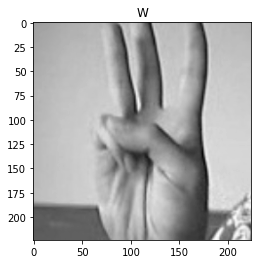

In [61]:
idx = 450
sample = transformed_dataset[idx]
image, label = sample
print(image.dtype)
plt.imshow(np.squeeze(image), cmap='gray')
plt.title(classes[label])

# Building CNN Architecture

In [14]:
# Hyperparameters
batch_size = 40

In [15]:
# Load data

# import libraries
from torch.utils.data import DataLoader

transform = transforms.Compose([Rescale(256),
                                RandomCrop(224),
                                Normalize(),
                                transforms.ToTensor()])

dataset = SignLanguageDataset(csv_dir, root_dir, transform=transform)
print(len(dataset))

train_set, test_set = torch.utils.data.random_split(dataset, [1200, 480])
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=True)

1680


In [16]:
print(len(train_loader))
print(len(test_loader))

30
12


In [18]:
# Build CNN Architecture

# Importing libraries
import torch
import torch.nn as nn

class Net(nn.Module):
  def __init__(self, in_channels=1, num_classes=24):
    super(Net,self).__init__()

    # conv layers
    self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=16, kernel_size=(3,3), stride=(1,1), padding=(1,1))
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), stride=(1,1), padding=(1,1))

    # pool layers
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # dense layers
    self.fc1 = nn.Linear(in_features=32*56*56, out_features=num_classes)

    # dropout regularization
    self.dropout = nn.Dropout(p=0.5)

    # activation function
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.reshape(x.shape[0], -1)
    x = self.fc1(x)
    return x

In [19]:
# Test CNN model

X = torch.randn(batch_size, 1, 224, 224)
net = Net()
output = net(X)
print(output.shape)

torch.Size([40, 24])
